<a href="https://colab.research.google.com/github/zlximon/Tensorflow_DL/blob/master/FoodVision2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Make sure  keep Runtime on GPU for best performance**

In [1]:
#downloading helper functions
!wget https://raw.githubusercontent.com/zlximon/Tensorflow_DL/master/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys,unzip_data


--2022-08-16 04:52:18--  https://raw.githubusercontent.com/zlximon/Tensorflow_DL/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-16 04:52:19 (108 MB/s) - ‘helper_functions.py’ saved [10246/10246]



#downloading data 

In [2]:
#tensorflow datasets
import tensorflow_datasets as tfds
import tensorflow as tf

In [3]:
# download dataset (here we use Food101 dataset )
 # it needs around 8 min to download and load the images  
(train_data,test_data),ds_info=tfds.load("food101",split=["train","validation"],
                                         shuffle_files=True,as_supervised=True,#the data gets returned in tuple format(data,label) for supervised learning  
                                         with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteXH56LH/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteXH56LH/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [4]:
#get our class names
class_names=ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [5]:
#How many class names we have
len(class_names)

101

In [6]:
#one example of train_data
train_sample=train_data.take(1)
train_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

#Visualizing images

In [7]:
for image,label in train_sample:
   print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 16
  Class name (str form): cheesecake
  


Text(0.5, 1.0, 'cheesecake')

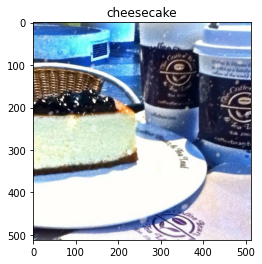

In [8]:
#Plotting an image
import matplotlib.pyplot as plt 
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list


In [9]:
# take 5 random images from training data
train_sample=(train_data.take(5))
train_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
for image,label in train_sample:
   print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 38
  Class name (str form): fish_and_chips
  

  Image shape: (384, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 83
  Class name (str form): red_velvet_cake
  

  Image shape: (384, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 99
  Class name (str form): tuna_tartare
  

  Image shape: (341, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 43
  Class name (str form): fried_calamari
  

  Image shape: (384, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 39
  Class name (str form): foie_gras
  


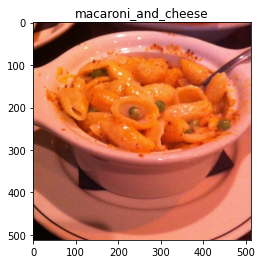

In [11]:
#plotting random images
import matplotlib.pyplot as plt 
for image,label in train_sample:
  plt.imshow(image)
  plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
  

#preprocessing function

In [12]:
def preprocess_img(image,label,img_shape=224):
  """
  converts image datatype from unit8 to float 32 and reshape image 
  """
  image=tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image,tf.float32),label

In [13]:
#map preprocessing for training data
train_data=train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)#use most of cpu for execute  
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
#map preprocessing for test data
test_data=test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [14]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# mixed_precision and callbacks

In [15]:
#create tensorboard 
from helper_functions import create_tensorboard_callback

checkpoint_patch="model_checkpoins/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_patch,monitor="val_acc",save_best_only=True,save_weights_only=True,verbose=0)

In [16]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")#set global data policy to mixed precision its speeding up our code so much
# the improvement are much noticable on larger models 

# download saved model and load it 
becuase fitting model and learning process takes about 60_65 minutes 
so to prevent wasting time , i trained and saved model previously and uploaded on Google Storage.
if you want see the process of creating Model, please go to the last section

In [17]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip


--2022-08-16 05:00:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 142.251.6.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46790356 (45M) [application/zip]
Saving to: ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  44.62M   188MB/s    in 0.2s    

2022-08-16 05:00:54 (188 MB/s) - ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’ saved [46790356/46790356]



In [18]:
!mkdir downloaded_fine_tuned_gs_model # create separate directory for fine-tuned model downloaded from Google Storage
!unzip /content/07_efficientnetb0_fine_tuned_101_classes_mixed_precision -d downloaded_fine_tuned_gs_model

Archive:  /content/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.index  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/saved_model.pb  
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets/


In [19]:
model = tf.keras.models.load_model("/content/downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision")


In [20]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-train

#evaluation 

In [21]:
result_fine=model.evaluate(test_data)

790/790 [==============================] - 62s 63ms/step - loss: 0.9073 - accuracy: 0.8017


In [22]:
pred_probs=model.predict(test_data,verbose=1)

790/790 [==============================] - 50s 62ms/step


In [23]:
pred_classes=pred_probs.argmax(axis=1)

In [24]:
# to get our class names , we need to unravel the test_data , bathdataset
y_labels=[]
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
  

#test data on custom images


In [25]:
def load_and_prep_image(filename, img_shape=224, scale=True):
 
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow

we have 101 diffrent classes and you can try any of them
Such as : 

In [26]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [27]:
#downlaod some of my own test images to see model performance 
!wget https://raw.githubusercontent.com/zlximon/Tensorflow_DL/master/Images.zip



--2022-08-16 05:04:37--  https://raw.githubusercontent.com/zlximon/Tensorflow_DL/master/Images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 992933 (970K) [application/zip]
Saving to: ‘Images.zip’

Images.zip          100%[===================>] 969.66K  --.-KB/s    in 0.05s   

2022-08-16 05:04:38 (18.8 MB/s) - ‘Images.zip’ saved [992933/992933]



In [28]:
import os
unzip_data("Images.zip")


In [29]:
custom_food_images = ["Images/" + img_path for img_path in os.listdir("Images")]
custom_food_images

['Images/test1.jpeg', 'Images/sushi1.jpg', 'Images/gs.jpg', 'Images/test2.jpg']

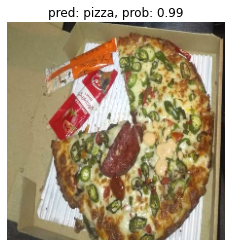

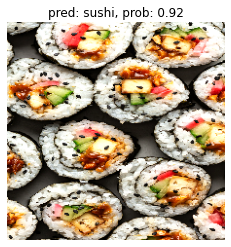

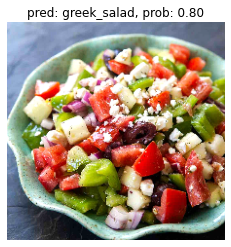

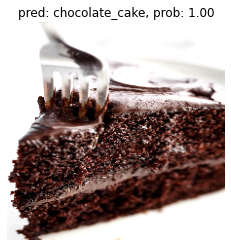

In [30]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # don't need to scale for our EfficientNetB0 model
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index with the highet prediction probability
  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/225.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

In [32]:
model_json = model.to_json()
with open("model_arch.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_weights.h5")

#Upload your custom images
if you want to try your own images , just run cell bellow and upload your photo

Saving Pefect-Cheesecake-7.jpg to Pefect-Cheesecake-7 (1).jpg
User uploaded file "Pefect-Cheesecake-7.jpg" with length 89460 bytes


(-0.5, 223.5, 223.5, -0.5)

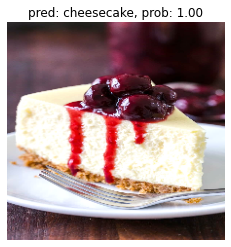

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
  IMAGE_NAME=fn
IMG_NAME = load_and_prep_image(IMAGE_NAME, scale=False) # don't need to scale for our EfficientNetB0 model
pred_prob = model.predict(tf.expand_dims(IMG_NAME, axis=0)) # make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
pred_class = class_names[pred_prob.argmax()] # get the index with the highet prediction probability
# Plot the appropriate information
plt.figure()
plt.imshow(IMG_NAME/225.)
plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
plt.axis(False)

##Model creation process


## feature extraction model


Creating a Model with Transfer learning and EfficientNetB0 pretrained model

In [70]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [71]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [72]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [73]:
# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220816-055705
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8230 - accuracy: 0.5558

2368/2368 [==============================] - 183s 73ms/step - loss: 1.8230 - accuracy: 0.5558 - val_loss: 1.2399 - val_accuracy: 0.6732
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2935 - accuracy: 0.6659

2368/2368 [==============================] - 172s 72ms/step - loss: 1.2935 - accuracy: 0.6659 - val_loss: 1.1291 - val_accuracy: 0.7018
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1436 - accuracy: 0.7018

2368/2368 [==============================] - 174s 73ms/step - loss: 1.1436 - accuracy: 0.7018 - val_loss: 1.0768 - val_accuracy: 0.7127


In [74]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 51s 64ms/step - loss: 1.0880 - accuracy: 0.7093


[1.0880457162857056, 0.7093465328216553]

In [ ]:
# Are any of the layers in our model frozen?
for layer in model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

In [76]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [82]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [78]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


This Training will take long time (about 1/5 hours )

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements